In [1]:
import os
import glob
import cv2
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import albumentations as A
import onnxruntime

## Loading samples' path in a dataframe

In [2]:
PATH = '../test-samples/'

mask_files = glob.glob(PATH + '*_mask*')
image_files = [file.replace('_mask', '') for file in mask_files]

def diagnosis(mask_path):
    return 1 if np.max(cv2.imread(mask_path)) > 0 else 0

samples_df = pd.DataFrame({"image_path": image_files,
                  "mask_path": mask_files,
                  "diagnosis": [diagnosis(x) for x in mask_files]})

samples_df

,image_path,mask_path,diagnosis
0,../test-samples/TCGA_CS_4942_19970222_11.tif,../test-samples/TCGA_CS_4942_19970222_11_mask.tif,1
1,../test-samples/TCGA_CS_4942_19970222_10.tif,../test-samples/TCGA_CS_4942_19970222_10_mask.tif,1
2,../test-samples/TCGA_CS_4941_19960909_15.tif,../test-samples/TCGA_CS_4941_19960909_15_mask.tif,1
3,../test-samples/TCGA_CS_4942_19970222_12.tif,../test-samples/TCGA_CS_4942_19970222_12_mask.tif,1


## Preprocessing Samples

In [3]:
def load_sample(idx):
    image = cv2.imread(samples_df.iloc[idx, 0])
    image = (np.array(image).astype(np.float32))/255.
    mask = cv2.imread(samples_df.iloc[idx, 1], 0)
    
    test_transform = A.Compose([
                    A.Resize(width=128, height=128, p=1.0)
                    ])
    
    aug = test_transform(image=image, mask=mask)
    image = aug['image']
    mask = aug['mask']
            
    image = image.transpose((2,0,1))
    
    #image normalize
    mean_vec = np.array([0.485, 0.456, 0.406])
    std_vec = np.array([0.229, 0.224, 0.225])

    for i in range(image.shape[0]):
        image[i, :, :] = (image[i, :, :] - mean_vec[i]) / (std_vec[i])
    
    
    mask = np.expand_dims(mask, axis=-1).transpose((2,0,1))

    return image, mask

In [4]:
test_img, test_mask = load_sample(3)

In [5]:
test_img.shape, test_mask.shape

((3, 128, 128), (1, 128, 128))

## Creating batch of single image

In [6]:
input_img = np.stack([test_img]*1)
input_img.shape

(1, 3, 128, 128)

## Loading the ONNX model

In [7]:
model_onnx = '../checkpoints/brain-mri-unet.onnx'

session = onnxruntime.InferenceSession(model_onnx, None)
input_name = session.get_inputs()[0].name
output_name = session.get_outputs()[0].name

## Predicting

In [8]:
result = session.run([output_name], {input_name: input_img})
result

[array([[[[4.8279762e-06, 8.1360340e-06, 2.8133392e-05, ...,
           2.2470951e-05, 1.0699034e-05, 7.9870224e-06],
          [3.2782555e-06, 3.7252903e-06, 2.4914742e-05, ...,
           1.7642975e-05, 4.5001507e-06, 6.7949295e-06],
          [1.7344952e-05, 3.6478043e-05, 5.3346157e-05, ...,
           5.7518482e-05, 2.1249056e-05, 2.0086765e-05],
          ...,
          [2.5600195e-05, 2.8073788e-05, 2.6404858e-05, ...,
           2.9861927e-05, 1.7762184e-05, 2.1457672e-05],
          [2.5302172e-05, 2.0265579e-05, 1.5795231e-05, ...,
           2.3424625e-05, 1.4752150e-05, 1.9222498e-05],
          [2.5659800e-05, 2.1100044e-05, 1.8715858e-05, ...,
           1.5109777e-05, 1.0699034e-05, 1.2695789e-05]]]], dtype=float32)]

In [9]:
arr = np.array(result).astype(np.float32)
arr = arr * 255
arr = arr[0, 0, 0, :, :].astype(np.uint8)
arr

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [10]:
arr.mean(), arr.var(), arr.min(), arr.max(), arr.shape

(5.561767578125, 1356.781951367855, 0, 254, (128, 128))

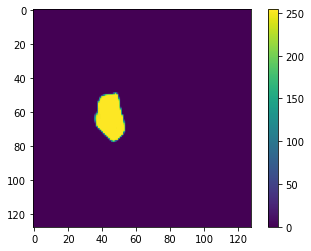

In [11]:
plt.imshow(arr)
plt.colorbar()

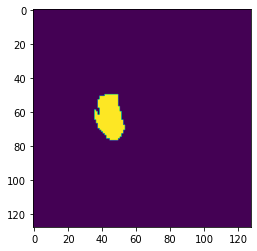

In [12]:
maskimg = test_mask[0, :, :]
plt.imshow(maskimg)